In [ ]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM,Bidirectional
from keras.layers import Dense
from keras.layers import Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd
import yfinance as yf

In [ ]:
def stacked_lstm(ticker,nodes,drop,epochs):

  #grab the data from yahoo finance
  data=yf.Ticker(ticker)
  stock_history=data.history(period="max")

  #convert the date in the data to datetime
  stock_history.reset_index(inplace=True)
  stock_history['Date'] =stock_history['Date'].dt.strftime('%Y/%m/%d')
  train_dates=pd.to_datetime(stock_history['Date'])

  #get the cols for training
  cols=list(stock_history)[1:6]
  stock_history.isnull().values.any()
  df_fortraining=stock_history[cols].astype(float)

  #standerdize data
  scaler=StandardScaler()
  scaler=scaler.fit(df_fortraining)
  df_scaled=scaler.transform(df_fortraining)

  trainX=[]
  trainY=[]

  n_future=1 # number of days we want to predict
  n_past=14 # number of days in past we want to use to make prediction

  for i in range(n_past, len(df_scaled) - n_future +1):
      trainX.append(df_scaled[i - n_past:i, 0:df_scaled.shape[1]])
      trainY.append(df_scaled[i + n_future - 1:i + n_future, 3])

  #convert to numpy array - which will change dimensions cause trainX is a list of lists rn
  trainX,trainY=np.array(trainX),np.array(trainY)

  #nodes=[50,50,100,100]
  # drop=0.7000000000000002

  model = tf.keras.Sequential([
  tf.keras.layers.LSTM(nodes[0], activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True),
  tf.keras.layers.LSTM(nodes[1], activation='relu', return_sequences=True),
  tf.keras.layers.LSTM(nodes[2], activation='relu', return_sequences=True),
  #tf.keras.layers.LSTM(nodes[0], activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True),
  #tf.keras.layers.LSTM(nodes[1], activation='relu', return_sequences=True),
  #tf.keras.layers.LSTM(nodes[2], activation='relu', return_sequences=True),
  #tf.keras.layers.LSTM(nodes[3], activation='relu', return_sequences=True),
  tf.keras.layers.LSTM(nodes[3], activation='relu', return_sequences=False),
  tf.keras.layers.Dense(500, activation='relu'),
  tf.keras.layers.Dense(500, activation='relu'),
  #tf.keras.layers.Dense(500, activation='relu'),
 #tf.keras.layers.Dense(500, activation='relu'),
  #tf.keras.layers.Dense(3000, activation='relu'),
  tf.keras.layers.Dropout(drop),
  tf.keras.layers.Dense(trainY.shape[1])
  ])
  epochs=epochs
  # Define a learning rate schedule
  learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate=0.001/epochs,
  decay_steps=10000,
  decay_rate=0.96
  )

  # Create an optimizer with the learning rate schedule
  optimizers = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)

  model.compile(optimizer=optimizers,loss='mean_squared_error')
  history=model.fit(
      trainX,
      trainY,
      validation_split=0.2,
      epochs=epochs,
    )

  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs_range = range(epochs)
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

  n_futures=365
  #train_dates[-1] is the current date or last date in the data, going till 90 days past
  forecast_period_dates = pd.date_range(list(train_dates)[-10], periods=n_futures, freq='1d').tolist()
  print(forecast_period_dates)

  #predict
  # use [-n_futures] becasue this is -90 which means take 90th last day as the starting date for the sequence then that day till the end of dataset(current date) to get 91st which is the output 1(1st day of 90 days or current date +1) then take the last 90th plus one so the 89th last day till the current date +1, which will predict the current day +2, do this until you are using last part of dataset(ie. current date) to current date+89 to get the current+90th day
  forecast=model.predict(trainX[-n_futures:])

  #forecasts_results.append(forecast)
  model.save_weights('%s.h5' % ticker)

  prediction_copies = np.repeat(forecast, df_fortraining.shape[1], axis=-1)
  y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
  #print(y_pred_future)
  forecast_dates = []
  for time_i in forecast_period_dates:
      forecast_dates.append(time_i.date())
  df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
  df_forecast['Date']=pd.to_datetime(df_forecast['Date'])
  print(model.summary())
  return df_forecast




In [ ]:
Ticker_List= [
'ASHOKLEY.NS',
'CANBK.NS',
'HEUBACHIND.NS',
'MORGANITE.BO',
'PETRONET.NS',
'RAMCOSYS.NS',
'RATEGAIN.NS',
'RHIM.NS',
'SI=F',
'ZOMATO.NS'
]


Epoch 1/50
137/137 [==============================] - 22s 99ms/step - loss: 0.2877 - val_loss: 0.2126
Epoch 2/50
137/137 [==============================] - 13s 96ms/step - loss: 0.0190 - val_loss: 0.2483
Epoch 3/50
137/137 [==============================] - 13s 97ms/step - loss: 0.0147 - val_loss: 0.2631
Epoch 4/50
137/137 [==============================] - 13s 96ms/step - loss: 0.0135 - val_loss: 0.2331
Epoch 5/50
137/137 [==============================] - 13s 96ms/step - loss: 0.0126 - val_loss: 0.3490
Epoch 6/50
137/137 [==============================] - 15s 106ms/step - loss: 0.0117 - val_loss: 0.2329
Epoch 7/50
137/137 [==============================] - 13s 96ms/step - loss: 0.0113 - val_loss: 0.2981
Epoch 8/50
137/137 [==============================] - 14s 98ms/step - loss: 0.0106 - val_loss: 0.2854
Epoch 9/50
137/137 [==============================] - 13s 96ms/step - loss: 0.0105 - val_loss: 0.2530
Epoch 10/50
137/137 [==============================] - 13s 94ms/step - loss: 0.01

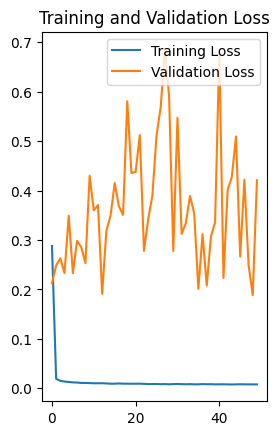

[Timestamp('2024-06-20 00:00:00'), Timestamp('2024-06-21 00:00:00'), Timestamp('2024-06-22 00:00:00'), Timestamp('2024-06-23 00:00:00'), Timestamp('2024-06-24 00:00:00'), Timestamp('2024-06-25 00:00:00'), Timestamp('2024-06-26 00:00:00'), Timestamp('2024-06-27 00:00:00'), Timestamp('2024-06-28 00:00:00'), Timestamp('2024-06-29 00:00:00'), Timestamp('2024-06-30 00:00:00'), Timestamp('2024-07-01 00:00:00'), Timestamp('2024-07-02 00:00:00'), Timestamp('2024-07-03 00:00:00'), Timestamp('2024-07-04 00:00:00'), Timestamp('2024-07-05 00:00:00'), Timestamp('2024-07-06 00:00:00'), Timestamp('2024-07-07 00:00:00'), Timestamp('2024-07-08 00:00:00'), Timestamp('2024-07-09 00:00:00'), Timestamp('2024-07-10 00:00:00'), Timestamp('2024-07-11 00:00:00'), Timestamp('2024-07-12 00:00:00'), Timestamp('2024-07-13 00:00:00'), Timestamp('2024-07-14 00:00:00'), Timestamp('2024-07-15 00:00:00'), Timestamp('2024-07-16 00:00:00'), Timestamp('2024-07-17 00:00:00'), Timestamp('2024-07-18 00:00:00'), Timestamp('20

Epoch 1/50
134/134 [==============================] - 18s 100ms/step - loss: 0.5321 - val_loss: 0.1576
Epoch 2/50
134/134 [==============================] - 13s 96ms/step - loss: 0.0809 - val_loss: 0.1061
Epoch 3/50
134/134 [==============================] - 13s 98ms/step - loss: 0.0663 - val_loss: 0.0877
Epoch 4/50
134/134 [==============================] - 13s 97ms/step - loss: 0.0568 - val_loss: 0.0784
Epoch 5/50
134/134 [==============================] - 13s 95ms/step - loss: 0.0542 - val_loss: 0.0952
Epoch 6/50
134/134 [==============================] - 13s 96ms/step - loss: 0.0517 - val_loss: 0.0437
Epoch 7/50
134/134 [==============================] - 13s 95ms/step - loss: 0.0498 - val_loss: 0.0540
Epoch 8/50
134/134 [==============================] - 13s 95ms/step - loss: 0.0463 - val_loss: 0.0461
Epoch 9/50
134/134 [==============================] - 13s 96ms/step - loss: 0.0446 - val_loss: 0.0249
Epoch 10/50
134/134 [==============================] - 15s 110ms/step - loss: 0.0

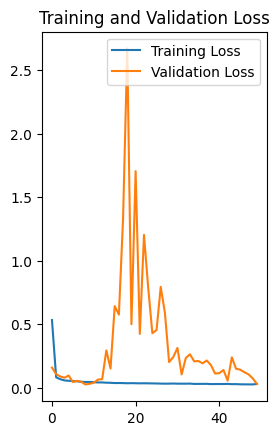

[Timestamp('2024-06-20 00:00:00'), Timestamp('2024-06-21 00:00:00'), Timestamp('2024-06-22 00:00:00'), Timestamp('2024-06-23 00:00:00'), Timestamp('2024-06-24 00:00:00'), Timestamp('2024-06-25 00:00:00'), Timestamp('2024-06-26 00:00:00'), Timestamp('2024-06-27 00:00:00'), Timestamp('2024-06-28 00:00:00'), Timestamp('2024-06-29 00:00:00'), Timestamp('2024-06-30 00:00:00'), Timestamp('2024-07-01 00:00:00'), Timestamp('2024-07-02 00:00:00'), Timestamp('2024-07-03 00:00:00'), Timestamp('2024-07-04 00:00:00'), Timestamp('2024-07-05 00:00:00'), Timestamp('2024-07-06 00:00:00'), Timestamp('2024-07-07 00:00:00'), Timestamp('2024-07-08 00:00:00'), Timestamp('2024-07-09 00:00:00'), Timestamp('2024-07-10 00:00:00'), Timestamp('2024-07-11 00:00:00'), Timestamp('2024-07-12 00:00:00'), Timestamp('2024-07-13 00:00:00'), Timestamp('2024-07-14 00:00:00'), Timestamp('2024-07-15 00:00:00'), Timestamp('2024-07-16 00:00:00'), Timestamp('2024-07-17 00:00:00'), Timestamp('2024-07-18 00:00:00'), Timestamp('20

Epoch 1/50
137/137 [==============================] - 19s 101ms/step - loss: 0.4280 - val_loss: 0.1452
Epoch 2/50
137/137 [==============================] - 13s 98ms/step - loss: 0.0266 - val_loss: 0.1972
Epoch 3/50
137/137 [==============================] - 13s 98ms/step - loss: 0.0228 - val_loss: 0.2577
Epoch 4/50
137/137 [==============================] - 13s 96ms/step - loss: 0.0210 - val_loss: 0.1161
Epoch 5/50
137/137 [==============================] - 13s 98ms/step - loss: 0.0195 - val_loss: 0.2509
Epoch 6/50
137/137 [==============================] - 13s 95ms/step - loss: 0.0181 - val_loss: 0.1930
Epoch 7/50
137/137 [==============================] - 13s 97ms/step - loss: 0.0176 - val_loss: 0.1802
Epoch 8/50
137/137 [==============================] - 13s 97ms/step - loss: 0.0167 - val_loss: 0.1903
Epoch 9/50
137/137 [==============================] - 14s 101ms/step - loss: 0.0162 - val_loss: 0.1916
Epoch 10/50
137/137 [==============================] - 14s 101ms/step - loss: 0.

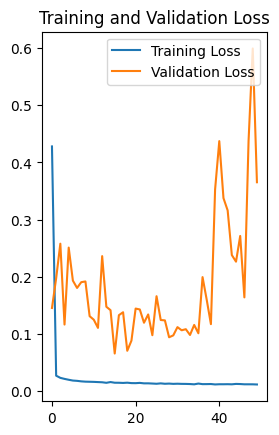

[Timestamp('2024-06-20 00:00:00'), Timestamp('2024-06-21 00:00:00'), Timestamp('2024-06-22 00:00:00'), Timestamp('2024-06-23 00:00:00'), Timestamp('2024-06-24 00:00:00'), Timestamp('2024-06-25 00:00:00'), Timestamp('2024-06-26 00:00:00'), Timestamp('2024-06-27 00:00:00'), Timestamp('2024-06-28 00:00:00'), Timestamp('2024-06-29 00:00:00'), Timestamp('2024-06-30 00:00:00'), Timestamp('2024-07-01 00:00:00'), Timestamp('2024-07-02 00:00:00'), Timestamp('2024-07-03 00:00:00'), Timestamp('2024-07-04 00:00:00'), Timestamp('2024-07-05 00:00:00'), Timestamp('2024-07-06 00:00:00'), Timestamp('2024-07-07 00:00:00'), Timestamp('2024-07-08 00:00:00'), Timestamp('2024-07-09 00:00:00'), Timestamp('2024-07-10 00:00:00'), Timestamp('2024-07-11 00:00:00'), Timestamp('2024-07-12 00:00:00'), Timestamp('2024-07-13 00:00:00'), Timestamp('2024-07-14 00:00:00'), Timestamp('2024-07-15 00:00:00'), Timestamp('2024-07-16 00:00:00'), Timestamp('2024-07-17 00:00:00'), Timestamp('2024-07-18 00:00:00'), Timestamp('20

Epoch 1/50
153/153 [==============================] - 20s 100ms/step - loss: 0.1970 - val_loss: 4.6199
Epoch 2/50
153/153 [==============================] - 16s 103ms/step - loss: 0.0160 - val_loss: 0.4033
Epoch 3/50
153/153 [==============================] - 15s 96ms/step - loss: 0.0105 - val_loss: 0.0838
Epoch 4/50
153/153 [==============================] - 15s 96ms/step - loss: 0.0100 - val_loss: 0.8370
Epoch 5/50
153/153 [==============================] - 15s 97ms/step - loss: 0.0087 - val_loss: 0.4370
Epoch 6/50
153/153 [==============================] - 15s 97ms/step - loss: 0.0085 - val_loss: 0.1690
Epoch 7/50
153/153 [==============================] - 16s 101ms/step - loss: 0.0086 - val_loss: 0.3614
Epoch 8/50
153/153 [==============================] - 15s 99ms/step - loss: 0.0079 - val_loss: 0.1376
Epoch 9/50
153/153 [==============================] - 15s 97ms/step - loss: 0.0078 - val_loss: 0.3644
Epoch 10/50
153/153 [==============================] - 15s 95ms/step - loss: 0.

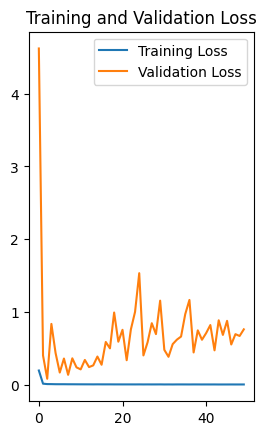

[Timestamp('2024-06-20 00:00:00'), Timestamp('2024-06-21 00:00:00'), Timestamp('2024-06-22 00:00:00'), Timestamp('2024-06-23 00:00:00'), Timestamp('2024-06-24 00:00:00'), Timestamp('2024-06-25 00:00:00'), Timestamp('2024-06-26 00:00:00'), Timestamp('2024-06-27 00:00:00'), Timestamp('2024-06-28 00:00:00'), Timestamp('2024-06-29 00:00:00'), Timestamp('2024-06-30 00:00:00'), Timestamp('2024-07-01 00:00:00'), Timestamp('2024-07-02 00:00:00'), Timestamp('2024-07-03 00:00:00'), Timestamp('2024-07-04 00:00:00'), Timestamp('2024-07-05 00:00:00'), Timestamp('2024-07-06 00:00:00'), Timestamp('2024-07-07 00:00:00'), Timestamp('2024-07-08 00:00:00'), Timestamp('2024-07-09 00:00:00'), Timestamp('2024-07-10 00:00:00'), Timestamp('2024-07-11 00:00:00'), Timestamp('2024-07-12 00:00:00'), Timestamp('2024-07-13 00:00:00'), Timestamp('2024-07-14 00:00:00'), Timestamp('2024-07-15 00:00:00'), Timestamp('2024-07-16 00:00:00'), Timestamp('2024-07-17 00:00:00'), Timestamp('2024-07-18 00:00:00'), Timestamp('20

Epoch 1/50
125/125 [==============================] - 18s 104ms/step - loss: 0.4476 - val_loss: 0.4830
Epoch 2/50
125/125 [==============================] - 12s 97ms/step - loss: 0.0347 - val_loss: 0.0863
Epoch 3/50
125/125 [==============================] - 12s 98ms/step - loss: 0.0255 - val_loss: 0.0682
Epoch 4/50
125/125 [==============================] - 12s 98ms/step - loss: 0.0224 - val_loss: 0.1576
Epoch 5/50
125/125 [==============================] - 12s 98ms/step - loss: 0.0191 - val_loss: 0.1562
Epoch 6/50
125/125 [==============================] - 12s 99ms/step - loss: 0.0177 - val_loss: 0.1244
Epoch 7/50
125/125 [==============================] - 12s 100ms/step - loss: 0.0165 - val_loss: 0.1006
Epoch 8/50
125/125 [==============================] - 12s 96ms/step - loss: 0.0148 - val_loss: 0.0994
Epoch 9/50
125/125 [==============================] - 12s 96ms/step - loss: 0.0148 - val_loss: 0.1281
Epoch 10/50
125/125 [==============================] - 13s 100ms/step - loss: 0.

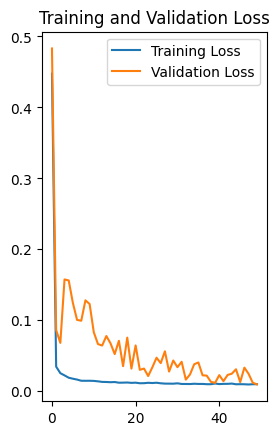

[Timestamp('2024-06-20 00:00:00'), Timestamp('2024-06-21 00:00:00'), Timestamp('2024-06-22 00:00:00'), Timestamp('2024-06-23 00:00:00'), Timestamp('2024-06-24 00:00:00'), Timestamp('2024-06-25 00:00:00'), Timestamp('2024-06-26 00:00:00'), Timestamp('2024-06-27 00:00:00'), Timestamp('2024-06-28 00:00:00'), Timestamp('2024-06-29 00:00:00'), Timestamp('2024-06-30 00:00:00'), Timestamp('2024-07-01 00:00:00'), Timestamp('2024-07-02 00:00:00'), Timestamp('2024-07-03 00:00:00'), Timestamp('2024-07-04 00:00:00'), Timestamp('2024-07-05 00:00:00'), Timestamp('2024-07-06 00:00:00'), Timestamp('2024-07-07 00:00:00'), Timestamp('2024-07-08 00:00:00'), Timestamp('2024-07-09 00:00:00'), Timestamp('2024-07-10 00:00:00'), Timestamp('2024-07-11 00:00:00'), Timestamp('2024-07-12 00:00:00'), Timestamp('2024-07-13 00:00:00'), Timestamp('2024-07-14 00:00:00'), Timestamp('2024-07-15 00:00:00'), Timestamp('2024-07-16 00:00:00'), Timestamp('2024-07-17 00:00:00'), Timestamp('2024-07-18 00:00:00'), Timestamp('20

Epoch 1/50
136/136 [==============================] - 20s 111ms/step - loss: 0.5981 - val_loss: 0.0778
Epoch 2/50
136/136 [==============================] - 13s 98ms/step - loss: 0.0686 - val_loss: 0.0547
Epoch 3/50
136/136 [==============================] - 13s 99ms/step - loss: 0.0587 - val_loss: 0.0405
Epoch 4/50
136/136 [==============================] - 13s 97ms/step - loss: 0.0472 - val_loss: 0.0391
Epoch 5/50
136/136 [==============================] - 13s 96ms/step - loss: 0.0446 - val_loss: 0.0415
Epoch 6/50
136/136 [==============================] - 13s 98ms/step - loss: 0.0451 - val_loss: 0.0453
Epoch 7/50
136/136 [==============================] - 14s 101ms/step - loss: 0.0376 - val_loss: 0.0371
Epoch 8/50
136/136 [==============================] - 14s 103ms/step - loss: 0.0387 - val_loss: 0.0371
Epoch 9/50
136/136 [==============================] - 14s 100ms/step - loss: 0.0362 - val_loss: 0.0364
Epoch 10/50
136/136 [==============================] - 14s 100ms/step - loss: 

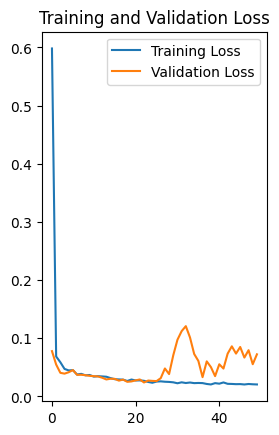

[Timestamp('2024-06-20 00:00:00'), Timestamp('2024-06-21 00:00:00'), Timestamp('2024-06-22 00:00:00'), Timestamp('2024-06-23 00:00:00'), Timestamp('2024-06-24 00:00:00'), Timestamp('2024-06-25 00:00:00'), Timestamp('2024-06-26 00:00:00'), Timestamp('2024-06-27 00:00:00'), Timestamp('2024-06-28 00:00:00'), Timestamp('2024-06-29 00:00:00'), Timestamp('2024-06-30 00:00:00'), Timestamp('2024-07-01 00:00:00'), Timestamp('2024-07-02 00:00:00'), Timestamp('2024-07-03 00:00:00'), Timestamp('2024-07-04 00:00:00'), Timestamp('2024-07-05 00:00:00'), Timestamp('2024-07-06 00:00:00'), Timestamp('2024-07-07 00:00:00'), Timestamp('2024-07-08 00:00:00'), Timestamp('2024-07-09 00:00:00'), Timestamp('2024-07-10 00:00:00'), Timestamp('2024-07-11 00:00:00'), Timestamp('2024-07-12 00:00:00'), Timestamp('2024-07-13 00:00:00'), Timestamp('2024-07-14 00:00:00'), Timestamp('2024-07-15 00:00:00'), Timestamp('2024-07-16 00:00:00'), Timestamp('2024-07-17 00:00:00'), Timestamp('2024-07-18 00:00:00'), Timestamp('20

Epoch 1/50
16/16 [==============================] - 7s 128ms/step - loss: 0.6289 - val_loss: 2.5156
Epoch 2/50
16/16 [==============================] - 1s 93ms/step - loss: 0.6019 - val_loss: 2.5057
Epoch 3/50
16/16 [==============================] - 1s 91ms/step - loss: 0.5515 - val_loss: 2.4789
Epoch 4/50
16/16 [==============================] - 1s 93ms/step - loss: 0.4421 - val_loss: 2.4191
Epoch 5/50
16/16 [==============================] - 2s 104ms/step - loss: 0.2501 - val_loss: 2.2581
Epoch 6/50
16/16 [==============================] - 3s 167ms/step - loss: 0.1976 - val_loss: 1.6593
Epoch 7/50
16/16 [==============================] - 1s 92ms/step - loss: 0.1258 - val_loss: 2.9293
Epoch 8/50
16/16 [==============================] - 1s 91ms/step - loss: 0.0837 - val_loss: 0.6404
Epoch 9/50
16/16 [==============================] - 1s 91ms/step - loss: 0.0689 - val_loss: 0.4755
Epoch 10/50
16/16 [==============================] - 1s 92ms/step - loss: 0.0607 - val_loss: 0.9842
Epoch 

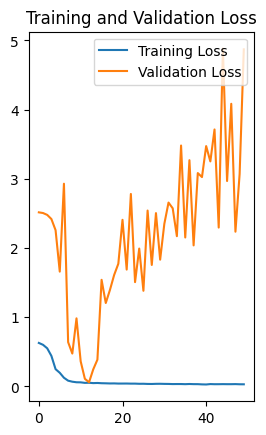

[Timestamp('2024-06-20 00:00:00'), Timestamp('2024-06-21 00:00:00'), Timestamp('2024-06-22 00:00:00'), Timestamp('2024-06-23 00:00:00'), Timestamp('2024-06-24 00:00:00'), Timestamp('2024-06-25 00:00:00'), Timestamp('2024-06-26 00:00:00'), Timestamp('2024-06-27 00:00:00'), Timestamp('2024-06-28 00:00:00'), Timestamp('2024-06-29 00:00:00'), Timestamp('2024-06-30 00:00:00'), Timestamp('2024-07-01 00:00:00'), Timestamp('2024-07-02 00:00:00'), Timestamp('2024-07-03 00:00:00'), Timestamp('2024-07-04 00:00:00'), Timestamp('2024-07-05 00:00:00'), Timestamp('2024-07-06 00:00:00'), Timestamp('2024-07-07 00:00:00'), Timestamp('2024-07-08 00:00:00'), Timestamp('2024-07-09 00:00:00'), Timestamp('2024-07-10 00:00:00'), Timestamp('2024-07-11 00:00:00'), Timestamp('2024-07-12 00:00:00'), Timestamp('2024-07-13 00:00:00'), Timestamp('2024-07-14 00:00:00'), Timestamp('2024-07-15 00:00:00'), Timestamp('2024-07-16 00:00:00'), Timestamp('2024-07-17 00:00:00'), Timestamp('2024-07-18 00:00:00'), Timestamp('20

Epoch 1/50
76/76 [==============================] - 14s 117ms/step - loss: 0.3019 - val_loss: 3.5397
Epoch 2/50
76/76 [==============================] - 7s 95ms/step - loss: 0.0305 - val_loss: 1.2016
Epoch 3/50
76/76 [==============================] - 9s 113ms/step - loss: 0.0129 - val_loss: 16.5253
Epoch 4/50
76/76 [==============================] - 8s 111ms/step - loss: 0.0101 - val_loss: 4.8273
Epoch 5/50
76/76 [==============================] - 7s 96ms/step - loss: 0.0096 - val_loss: 1.7995
Epoch 6/50
76/76 [==============================] - 9s 114ms/step - loss: 0.0085 - val_loss: 0.4831
Epoch 7/50
76/76 [==============================] - 8s 99ms/step - loss: 0.0085 - val_loss: 0.2392
Epoch 8/50
76/76 [==============================] - 8s 103ms/step - loss: 0.0077 - val_loss: 0.2969
Epoch 9/50
76/76 [==============================] - 8s 107ms/step - loss: 0.0084 - val_loss: 0.1768
Epoch 10/50
76/76 [==============================] - 7s 92ms/step - loss: 0.0076 - val_loss: 0.3263
E

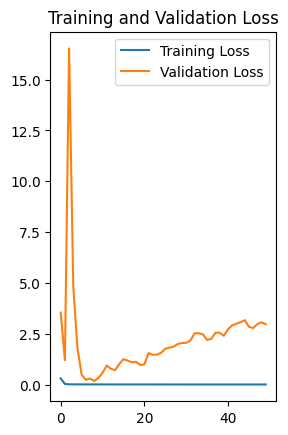

[Timestamp('2024-06-20 00:00:00'), Timestamp('2024-06-21 00:00:00'), Timestamp('2024-06-22 00:00:00'), Timestamp('2024-06-23 00:00:00'), Timestamp('2024-06-24 00:00:00'), Timestamp('2024-06-25 00:00:00'), Timestamp('2024-06-26 00:00:00'), Timestamp('2024-06-27 00:00:00'), Timestamp('2024-06-28 00:00:00'), Timestamp('2024-06-29 00:00:00'), Timestamp('2024-06-30 00:00:00'), Timestamp('2024-07-01 00:00:00'), Timestamp('2024-07-02 00:00:00'), Timestamp('2024-07-03 00:00:00'), Timestamp('2024-07-04 00:00:00'), Timestamp('2024-07-05 00:00:00'), Timestamp('2024-07-06 00:00:00'), Timestamp('2024-07-07 00:00:00'), Timestamp('2024-07-08 00:00:00'), Timestamp('2024-07-09 00:00:00'), Timestamp('2024-07-10 00:00:00'), Timestamp('2024-07-11 00:00:00'), Timestamp('2024-07-12 00:00:00'), Timestamp('2024-07-13 00:00:00'), Timestamp('2024-07-14 00:00:00'), Timestamp('2024-07-15 00:00:00'), Timestamp('2024-07-16 00:00:00'), Timestamp('2024-07-17 00:00:00'), Timestamp('2024-07-18 00:00:00'), Timestamp('20

Epoch 1/50
150/150 [==============================] - 22s 108ms/step - loss: 0.5647 - val_loss: 0.1164
Epoch 2/50
150/150 [==============================] - 15s 100ms/step - loss: 0.0602 - val_loss: 0.0635
Epoch 3/50
150/150 [==============================] - 15s 100ms/step - loss: 0.0466 - val_loss: 0.0476
Epoch 4/50
150/150 [==============================] - 15s 97ms/step - loss: 0.0396 - val_loss: 0.0386
Epoch 5/50
150/150 [==============================] - 15s 100ms/step - loss: 0.0374 - val_loss: 0.0338
Epoch 6/50
150/150 [==============================] - 16s 104ms/step - loss: 0.0354 - val_loss: 0.0307
Epoch 7/50
150/150 [==============================] - 15s 98ms/step - loss: 0.0360 - val_loss: 0.0351
Epoch 8/50
150/150 [==============================] - 15s 99ms/step - loss: 0.0324 - val_loss: 0.0296
Epoch 9/50
150/150 [==============================] - 15s 99ms/step - loss: 0.0312 - val_loss: 0.0283
Epoch 10/50
150/150 [==============================] - 15s 99ms/step - loss: 

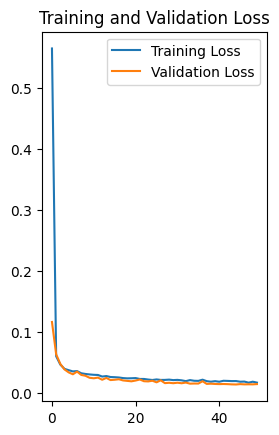

[Timestamp('2024-06-20 00:00:00'), Timestamp('2024-06-21 00:00:00'), Timestamp('2024-06-22 00:00:00'), Timestamp('2024-06-23 00:00:00'), Timestamp('2024-06-24 00:00:00'), Timestamp('2024-06-25 00:00:00'), Timestamp('2024-06-26 00:00:00'), Timestamp('2024-06-27 00:00:00'), Timestamp('2024-06-28 00:00:00'), Timestamp('2024-06-29 00:00:00'), Timestamp('2024-06-30 00:00:00'), Timestamp('2024-07-01 00:00:00'), Timestamp('2024-07-02 00:00:00'), Timestamp('2024-07-03 00:00:00'), Timestamp('2024-07-04 00:00:00'), Timestamp('2024-07-05 00:00:00'), Timestamp('2024-07-06 00:00:00'), Timestamp('2024-07-07 00:00:00'), Timestamp('2024-07-08 00:00:00'), Timestamp('2024-07-09 00:00:00'), Timestamp('2024-07-10 00:00:00'), Timestamp('2024-07-11 00:00:00'), Timestamp('2024-07-12 00:00:00'), Timestamp('2024-07-13 00:00:00'), Timestamp('2024-07-14 00:00:00'), Timestamp('2024-07-15 00:00:00'), Timestamp('2024-07-16 00:00:00'), Timestamp('2024-07-17 00:00:00'), Timestamp('2024-07-18 00:00:00'), Timestamp('20

Epoch 1/50
18/18 [==============================] - 8s 199ms/step - loss: 0.6424 - val_loss: 2.4256
Epoch 2/50
18/18 [==============================] - 2s 96ms/step - loss: 0.6100 - val_loss: 2.4154
Epoch 3/50
18/18 [==============================] - 2s 94ms/step - loss: 0.5255 - val_loss: 2.3852
Epoch 4/50
18/18 [==============================] - 2s 91ms/step - loss: 0.3531 - val_loss: 2.2956
Epoch 5/50
18/18 [==============================] - 2s 92ms/step - loss: 0.2080 - val_loss: 2.0360
Epoch 6/50
18/18 [==============================] - 2s 92ms/step - loss: 0.1418 - val_loss: 0.9528
Epoch 7/50
18/18 [==============================] - 2s 131ms/step - loss: 0.0742 - val_loss: 2.2760
Epoch 8/50
18/18 [==============================] - 2s 128ms/step - loss: 0.0535 - val_loss: 0.8761
Epoch 9/50
18/18 [==============================] - 2s 91ms/step - loss: 0.0525 - val_loss: 0.5036
Epoch 10/50
18/18 [==============================] - 2s 93ms/step - loss: 0.0483 - val_loss: 0.3926
Epoch 

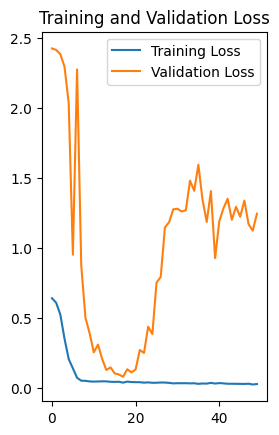

[Timestamp('2024-06-20 00:00:00'), Timestamp('2024-06-21 00:00:00'), Timestamp('2024-06-22 00:00:00'), Timestamp('2024-06-23 00:00:00'), Timestamp('2024-06-24 00:00:00'), Timestamp('2024-06-25 00:00:00'), Timestamp('2024-06-26 00:00:00'), Timestamp('2024-06-27 00:00:00'), Timestamp('2024-06-28 00:00:00'), Timestamp('2024-06-29 00:00:00'), Timestamp('2024-06-30 00:00:00'), Timestamp('2024-07-01 00:00:00'), Timestamp('2024-07-02 00:00:00'), Timestamp('2024-07-03 00:00:00'), Timestamp('2024-07-04 00:00:00'), Timestamp('2024-07-05 00:00:00'), Timestamp('2024-07-06 00:00:00'), Timestamp('2024-07-07 00:00:00'), Timestamp('2024-07-08 00:00:00'), Timestamp('2024-07-09 00:00:00'), Timestamp('2024-07-10 00:00:00'), Timestamp('2024-07-11 00:00:00'), Timestamp('2024-07-12 00:00:00'), Timestamp('2024-07-13 00:00:00'), Timestamp('2024-07-14 00:00:00'), Timestamp('2024-07-15 00:00:00'), Timestamp('2024-07-16 00:00:00'), Timestamp('2024-07-17 00:00:00'), Timestamp('2024-07-18 00:00:00'), Timestamp('20

In [ ]:
nodes=[1000,1000,50,50]
drop=0.6
# stacked_lstm('NET',nodes,drop,50)
# SITM=stacked_lstm('SITM',nodes,drop,50)
ASHOKLEY = stacked_lstm('ASHOKLEY.NS',nodes,drop,50)
CANBK = stacked_lstm('CANBK.NS',nodes,drop,50)
HEUBACHIND = stacked_lstm('HEUBACHIND.NS',nodes,drop,50)
MORGANITE = stacked_lstm('MORGANITE.BO',nodes,drop,50)
PETRONET = stacked_lstm('PETRONET.NS',nodes,drop,50)
RAMCOSYS = stacked_lstm('RAMCOSYS.NS',nodes,drop,50)
RATEGAIN = stacked_lstm('RATEGAIN.NS', nodes, drop, 50)
RHIM = stacked_lstm('RHIM.NS', nodes, drop, 50)
SI = stacked_lstm('SI=F', nodes, drop, 50)
ZOMATO = stacked_lstm('ZOMATO.NS', nodes, drop, 50)

In [ ]:
stocks_data = [ASHOKLEY,
CANBK,
HEUBACHIND,
MORGANITE,
PETRONET,
RAMCOSYS,
RATEGAIN,
RHIM,
SI,
ZOMATO]


ASHOKLEY.rename(columns={"ASHOKLEY": "ASHOKLEY"}, inplace=True)

CANBK.rename(columns={"OPEN": "CANBK"}, inplace=True)
CANBK = CANBK.drop(['Date'], axis=1)

HEUBACHIND.rename(columns={"OPEN": "HEUBACHIND"}, inplace=True)
HEUBACHIND = HEUBACHIND.drop(['Date'], axis=1)

MORGANITE.rename(columns={"OPEN": "MORGANITE"}, inplace=True)
MORGANITE = MORGANITE.drop(['Date'], axis=1)

PETRONET.rename(columns={"OPEN": "PETRONET"}, inplace=True)
PETRONET = PETRONET.drop(['Date'], axis=1)

RAMCOSYS.rename(columns={"OPEN": "RAMCOSYS"}, inplace=True)
RAMCOSYS = RAMCOSYS.drop(['Date'], axis=1)

RATEGAIN.rename(columns={"OPEN": "RATEGAIN"}, inplace=True)
RATEGAIN = RATEGAIN.drop(['Date'], axis=1)

RHIM.rename(columns={"OPEN": "RHIM"}, inplace=True)
RHIM = RHIM.drop(['Date'], axis=1)

SI.rename(columns={"OPEN": "SI"}, inplace=True)
SI = SI.drop(['Date'], axis=1)

ZOMATO.rename(columns={"OPEN": "ZOMATO"}, inplace=True)
ZOMATO = ZOMATO.drop(['Date'], axis=1)

In [ ]:
result = pd.concat([ASHOKLEY,
CANBK,
HEUBACHIND,
MORGANITE,
PETRONET,
RAMCOSYS,
RATEGAIN,
RHIM,
SI,
ZOMATO], axis=1)


In [ ]:
result.to_csv('stocks_predicted_data.csv', index=False)

In [8]:
import pandas as pd
import numpy as np

# Load historical data and predicted prices
historical_data = pd.read_excel('new.xlsx')
predicted_prices = pd.read_excel('stocks_predicted_data.xlsx')

In [11]:
historical_data = historical_data.drop('DATE', axis=1)
predicted_prices = predicted_prices.drop('DATE', axis=1)

In [13]:
# Calculate expected returns from predicted prices
current_prices = historical_data.iloc[-1]
expected_returns = (predicted_prices - current_prices) / current_prices

# Calculate the covariance matrix from historical data
returns = historical_data.pct_change().dropna()
cov_matrix = returns.cov()
cov_matrix

,ASHOKLEY,CANBK,HEUBACHIND,MORGANITE,PETRONET,RAMCOSYS,RATEGAIN,RHIM,SI,ZOMATO
ASHOKLEY,1.579200e-04,0.000055,-4.754663e-07,0.000016,0.000021,0.000016,0.000018,0.002004,-0.000006,-0.000005
CANBK,5.544559e-05,0.001185,-8.516978e-05,0.000008,0.000059,0.000185,0.000032,-0.002858,-0.000021,-0.000087
HEUBACHIND,-4.754663e-07,-0.000085,3.431300e-04,-0.000017,0.000023,-0.000478,0.000002,0.006797,0.000005,0.000032
MORGANITE,1.645689e-05,0.000008,-1.712252e-05,0.000108,-0.000004,0.000059,0.000044,-0.002334,-0.000013,-0.000022
PETRONET,2.050399e-05,0.000059,2.312906e-05,-0.000004,0.000062,-0.000062,0.000017,-0.000490,0.000001,0.000003
RAMCOSYS,1.640529e-05,0.000185,-4.784928e-04,0.000059,-0.000062,0.008768,0.000064,0.006761,0.000005,0.000108
RATEGAIN,1.776958e-05,0.000032,2.056113e-06,0.000044,0.000017,0.000064,0.000395,-0.008897,0.000004,-0.000022
RHIM,2.004474e-03,-0.002858,6.796819e-03,-0.002334,-0.000490,0.006761,-0.008897,30.371410,-0.000647,-0.005978
SI,-5.957117e-06,-0.000021,4.830208e-06,-0.000013,0.000001,0.000005,0.000004,-0.000647,0.000056,0.000009
ZOMATO,-5.443626e-06,-0.000087,3.225492e-05,-0.000022,0.000003,0.000108,-0.000022,-0.005978,0.000009,0.000136


In [14]:
from scipy.optimize import minimize

# Define the objective function (negative of expected return)
def objective(weights, expected_returns):
    return -np.dot(weights, expected_returns)

# Define the constraint (sum of weights equals 1)
def constraint(weights):
    return np.sum(weights) - 1

# Define bounds for weights (no short selling, weights between 0 and 1)
bounds = [(0, 1) for _ in range(len(expected_returns.columns))]

# Initial guess (equal distribution)
initial_guess = np.array([1/len(expected_returns.columns)] * len(expected_returns.columns))

# Optimization
opt_results = minimize(objective, initial_guess, args=(expected_returns.mean(),),
                       method='SLSQP', bounds=bounds, constraints={'type': 'eq', 'fun': constraint})

# Optimal weights
optimal_weights = opt_results.x
print("Optimal Weights:", optimal_weights)


Optimal Weights: [0.00000000e+00 5.31519273e-15 1.00000000e+00 0.00000000e+00
 2.39391840e-15 0.00000000e+00 0.00000000e+00 2.05217787e-14
 5.50948176e-15 6.12357387e-15]


In [17]:
# Current portfolio value and current weights
current_investments = {'ASHOKLEY': 980, 'CANBK': 1575, 'HEUBACHIND': 1832, 'MORGANITE': 1435,
                       'PETRONET': 308, 'RAMCOSYS': 931, 'RATEGAIN': 1390, 'RHIM': 1218,
                       'SI': 3531, 'ZOMATO': 862}

current_portfolio_value = sum(current_investments.values())
current_weights = np.array([value / current_portfolio_value for value in current_investments.values()])

# Calculate amount to buy/sell for rebalancing
target_portfolio_value = current_portfolio_value * optimal_weights
amount_to_trade = target_portfolio_value - np.array(list(current_investments.values()))

# Output trade instructions
trade_instructions = {stock: amount for stock, amount in zip(current_investments.keys(), amount_to_trade)}
print("Trade Instructions:", trade_instructions)


Trade Instructions: {'ASHOKLEY': -980.0, 'CANBK': -1574.9999999999252, 'HEUBACHIND': 12229.9999999997, 'MORGANITE': -1435.0, 'PETRONET': -307.99999999996635, 'RAMCOSYS': -931.0, 'RATEGAIN': -1390.0, 'RHIM': -1217.9999999997115, 'SI': -3530.9999999999227, 'ZOMATO': -861.9999999999139}


In [19]:
# Define stop-loss levels (e.g., 10% below current prices)
stop_loss_levels = {stock: current_prices[stock] * 0.9 for stock in current_prices.index}
print("Stop-Loss Levels:", stop_loss_levels)

# Example function to execute trades
def execute_trades(trade_instructions, stop_loss_levels):
    # Placeholder function for executing trades and setting stop-loss orders
    # This function would interface with a brokerage API to place trades
    for stock, amount in trade_instructions.items():
        if amount > 0:
            print(f"Buy {amount} of {stock}")
        else:
            print(f"Sell {abs(amount)} of {stock}")
        print(f"Set stop-loss for {stock} at {stop_loss_levels[stock]}")

# Execute trades
execute_trades(trade_instructions, stop_loss_levels)


Stop-Loss Levels: {'ASHOKLEY': 118.59411600000001, 'CANBK': 101.9726325, 'HEUBACHIND': 353.674953, 'MORGANITE': 575.886843, 'PETRONET': 224.32737600000002, 'RAMCOSYS': 316.281285, 'RATEGAIN': 538.121835, 'RHIM': -38.9835945, 'SI': 26.3908134, 'ZOMATO': 196.551261}
Sell 980.0 of ASHOKLEY
Set stop-loss for ASHOKLEY at 118.59411600000001
Sell 1574.9999999999252 of CANBK
Set stop-loss for CANBK at 101.9726325
Buy 12229.9999999997 of HEUBACHIND
Set stop-loss for HEUBACHIND at 353.674953
Sell 1435.0 of MORGANITE
Set stop-loss for MORGANITE at 575.886843
Sell 307.99999999996635 of PETRONET
Set stop-loss for PETRONET at 224.32737600000002
Sell 931.0 of RAMCOSYS
Set stop-loss for RAMCOSYS at 316.281285
Sell 1390.0 of RATEGAIN
Set stop-loss for RATEGAIN at 538.121835
Sell 1217.9999999997115 of RHIM
Set stop-loss for RHIM at -38.9835945
Sell 3530.9999999999227 of SI
Set stop-loss for SI at 26.3908134
Sell 861.9999999999139 of ZOMATO
Set stop-loss for ZOMATO at 196.551261
